In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [ ]:
import pandas as pd

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ag_news_test.csv to ag_news_test (2).csv
Saving ag_news_train.csv to ag_news_train (2).csv


In [ ]:
data_train = pd.read_csv('ag_news_train.csv', na_values='NaN', names=['class', 'title', 'description'])
data_test = pd.read_csv('ag_news_test.csv', na_values='NaN', names=['class', 'title', 'description'])

In [ ]:
data_train

,class,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."
...,...,...,...
119995,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119996,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119997,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119998,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


In [ ]:
data_test

,class,title,description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...
...,...,...,...
7595,1,Around the world,Ukrainian presidential candidate Viktor Yushch...
7596,2,Void is filled with Clement,With the supply of attractive pitching options...
7597,2,Martinez leaves bitter,Like Roger Clemens did almost exactly eight ye...
7598,3,5 of arthritis patients in Singapore take Bext...,SINGAPORE : Doctors in the United States have ...


In [ ]:
VOCAB_SIZE = 20000
MAXLEN = 200
EPOCH = 10
BATCHSIZE = 32

In [ ]:
x_train = []
y_train = []
for cl, title, desc in data_train[['class', 'title', 'description']].values:
  x_train.append(title + desc)
  y_train.append(cl-1)

x_test = []
y_test = []
for cl, title, desc in data_test[['class', 'title', 'description']].values:
  x_test.append(title + desc)
  y_test.append(cl-1)

In [ ]:
print(len(x_train), "Training sequences")
print(len(x_test), "Test sequences")

120000 Training sequences
7600 Test sequences


In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [ ]:
x_tokenizer = Tokenizer(num_words=VOCAB_SIZE)
x_tokenizer.fit_on_texts(x_train)
x_index = x_tokenizer.word_index

In [ ]:
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_test_seq = x_tokenizer.texts_to_sequences(x_test)

In [ ]:
x_train_seq_pad = pad_sequences(x_train_seq, maxlen=MAXLEN)
x_test_seq_pad = pad_sequences(x_test_seq, maxlen=MAXLEN)

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(MAXLEN,))
embedding_layer = TokenAndPositionEmbedding(MAXLEN, VOCAB_SIZE, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(4, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train_seq_pad.tolist(), y_train, batch_size=BATCHSIZE, epochs=EPOCH, validation_data=(x_test_seq_pad.tolist(), y_test)
)

Epoch 1/10
3750/3750 [==============================] - 561s 149ms/step - loss: 0.5913 - accuracy: 0.7539 - val_loss: 0.2705 - val_accuracy: 0.9113
Epoch 2/10
3750/3750 [==============================] - 694s 185ms/step - loss: 0.2121 - accuracy: 0.9314 - val_loss: 0.2489 - val_accuracy: 0.9191
Epoch 3/10
3750/3750 [==============================] - 625s 167ms/step - loss: 0.1627 - accuracy: 0.9441 - val_loss: 0.2608 - val_accuracy: 0.9142
Epoch 4/10
3750/3750 [==============================] - 558s 149ms/step - loss: 0.1317 - accuracy: 0.9519 - val_loss: 0.3378 - val_accuracy: 0.9072
Epoch 5/10
3750/3750 [==============================] - 521s 139ms/step - loss: 0.1104 - accuracy: 0.9581 - val_loss: 0.3344 - val_accuracy: 0.9074
Epoch 6/10
3750/3750 [==============================] - 526s 140ms/step - loss: 0.0979 - accuracy: 0.9611 - val_loss: 0.3796 - val_accuracy: 0.9080
Epoch 7/10
3750/3750 [==============================] - 552s 147ms/step - loss: 0.0830 - accuracy: 0.9666 - val_

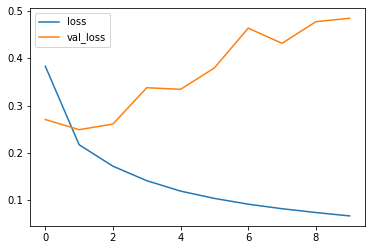

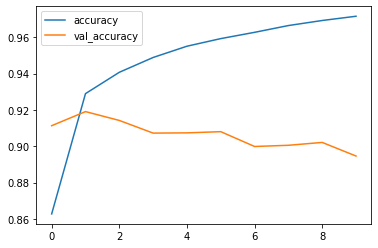

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()